# Visualization of machine learning performance with AUC
##### Samo Turk, Team SKI, BioMed X Innovation center
This notebook should be run locally because it includes interactive widgets which might not be rendered properly by GitHub.
Some functionality might need https://github.com/ipython-contrib/jupyter_contrib_nbextensions/ (optional)

In [1]:
% matplotlib inline
from __future__ import print_function

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc, recall_score, accuracy_score, cohen_kappa_score, log_loss
from sklearn.datasets.samples_generator import make_blobs
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.cross_validation import train_test_split
from ipywidgets import interact, fixed

/home/samo/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
plt.style.use('bmh')

In [4]:
def make_data(positives, negatives, dist, random_state=5):
    """
    Generates 2 blobs of data seperated by dist.
    """
    X_p,y = make_blobs(n_samples=positives, centers=np.array([[0,1]]), 
                       random_state=random_state)
    X_n,y = make_blobs(n_samples=negatives, centers=np.array([[0+dist,1-dist]]), 
                       random_state=random_state + 1) # + 1 is to make sure the two have different random states
    y_p = np.ones(len(X_p), np.int)
    y_n = np.zeros(len(X_n), np.int)
    X = np.vstack((X_p, X_n))
    y = np.hstack((y_p, y_n))
    data = list(zip(X,y))
    np.random.shuffle(data)
    xs = []
    ys = []
    for x,y in data:
        xs.append(x)
        ys.append(y)
    X = np.vstack(xs)
    y = np.array(ys)
    return X, y

def plot_blobs(X,y):
    fig = plt.figure(figsize=(3,2), dpi=80)
    axes = fig.add_axes([0, 0, 1, 1])
    axes.scatter(X[y==0].T[0], X[y==0].T[1], color='r', marker='o', edgecolors='w', alpha=0.5)
    axes.scatter(X[y==1].T[0], X[y==1].T[1], color='b', marker='o', edgecolors='w', alpha=0.5)
    axes.set_xlabel('feature 1')
    axes.set_ylabel('feature 2')
    return fig

## Generating data
2 blobs of points seperated by certain distance

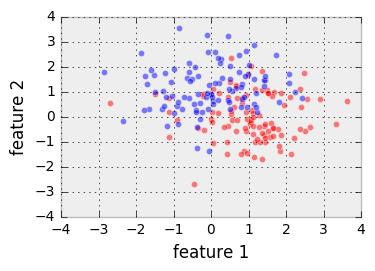

In [5]:
plot_blobs(*make_data(100, 100, 1));

## Train the model and test it on test set

In [6]:
X_train, X_test, y_train, y_test = train_test_split(*make_data(1000, 1000, 1))
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

In [7]:
def plot_hist(y, scores, title, size=(1.5,1.5)):
    fig = plt.figure(figsize=size, dpi=80)
    axes = fig.add_axes([0, 0, 1, 1])
    bins = np.linspace(0, 1, 11)
    axes.hist([x[0] for x in zip(scores, y) if x[1] == 1], bins, alpha=0.5, color= 'b')
    axes.hist([x[0] for x in zip(scores, y) if x[1] == 0], bins, alpha=0.5, color= 'r')
    axes.vlines(0.5, 0, np.histogram(scores, bins)[0].max(), color='black', linestyles='--')
    axes.set_ylim((0, np.histogram(scores, bins)[0].max()))
    axes.set_xlabel(title)
    axes.set_ylabel('#')
    return fig

def plot_ROC(observations, probabilities, title="", labels=True, size='auto'):
    """
    Creates ROC plot from observations (y_test) and probabilities (y_pred_proba)
    title -- title of the plot
    size -- tuple, size in inch, defaults to 'auto'
    labels -- toogle display of title and x and y labels and tick labels
    """
    if size is 'auto':
        fig = plt.figure()
    else:
        fig = plt.figure(num=None, figsize=size, dpi=80)
    axes = fig.add_axes([0, 0, 1, 1])
    fpr, tpr, thresholds = roc_curve(observations, probabilities)
    #roc_auc = auc(fpr, tpr)
    #print "Area under the ROC curve : %f" % roc_auc
    axes.plot(fpr, tpr)
    axes.plot([0, 1], [0, 1], 'k--')
    axes.set_aspect('equal')
    if labels:
        axes.set_title(title)
        axes.set_xlabel('False Positive Rate')
        axes.set_ylabel('True Positive Rate')
    else:
        axes.get_xaxis().set_ticks([])
        axes.get_yaxis().set_ticks([])
    return fig

Plot score distribution

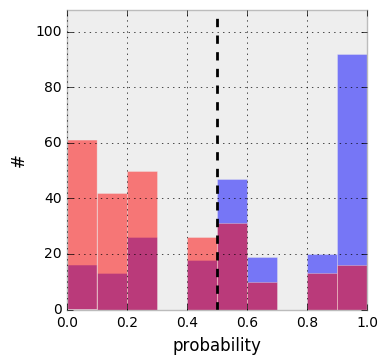

In [8]:
plot_hist(y_test, y_pred_proba.T[1], 'probability', size=(3,3));

Plot ROC curve

AUC: 0.767


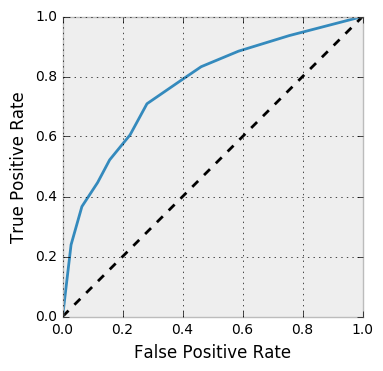

In [9]:
print("AUC: %.3f" % roc_auc_score(y_test, y_pred_proba.T[1]))
plot_ROC(y_test, y_pred_proba.T[1], size=(3,3));

In [10]:
def classifier_eval(positives=1000, negatives=1000, seperation=1, random_state=1, classifier=RandomForestClassifier):
    X,y = make_data(positives, negatives, seperation, random_state=random_state,)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    clf = classifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    recall1 = recall_score(y_test, y_pred, pos_label=1)
    recall0 = recall_score(y_test, y_pred, pos_label=0)
    auc = roc_auc_score(y_test, y_pred_proba.T[1])
    accuracy = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    print("AUC: %.3f\nRecall 1: %.2f, Recall 0: %.2f\nAccuracy: %.2f\nkappa: %.2f" 
          % (auc,recall1,recall0,accuracy, kappa))
    plot_blobs(X,y);
    plot_hist(y_test, y_pred_proba.T[1], 'probability', size=(1.5,1.5));
    plot_ROC(y_test, y_pred_proba.T[1], size=(1.5,1.5));


### Classifier performance evaluaion on different sets
Data is generated on the fly, each time a new widget value is selected
* positives -- number of samples in positive class
* negatives -- number of samples in negative class
* separation -- distance between blob centres
* classifier -- any classifier that calculates probabilities
##### Classifiers that calculate pobabilites:  
* RandomForestClassifier
* AdaBoostClassifier
* ExtraTreesClassifier
* GradientBoostingClassifier

AUC: 0.775
Recall 1: 0.66, Recall 0: 0.76
Accuracy: 0.71
kappa: 0.42


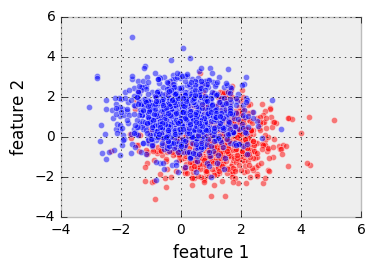

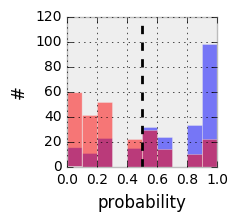

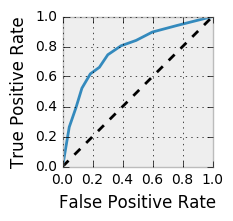

In [11]:
interact(classifier_eval, positives=[100,10000,100], negatives=[100,10000,100], 
         seperation=[0, 10, 0.1], random_state=[1,5], 
         classifier={'Random Forest':RandomForestClassifier, 'Ada Boost':AdaBoostClassifier, 
                     'Gradient Boosting':GradientBoostingClassifier, 'Extra Trees':ExtraTreesClassifier, });

More about in [IPython widgets](https://ipywidgets.readthedocs.io/en/latest/)



Copyright (C) 2016 by Samo Turk, BioMed X GmbH

This work is licensed under the Attribution 4.0 International (CC BY 4.0). To view a copy of this license, visit http://creativecommons.org/licenses/by/4.0/ or send a letter to Creative Commons, 543 Howard Street, 5th Floor, San Francisco, California, 94105, USA.
